In [1]:
import os, cv2
import numpy as np
from utils import draw_boxes
import time
import matplotlib.pyplot as plt
%matplotlib inline


/home/kandithws/ait_workspace/MachineLearning/deeplearn-venv/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Input
from keras.layers import Convolution2D, MaxPooling2D
from keras import backend as K
from keras.applications.inception_v3 import InceptionV3

Using TensorFlow backend.


In [3]:
os.environ["PRETRAIN_BACKEND_PATH"] = "/home/kandithws/ait_workspace/MachineLearning/pretrained_models/"

In [4]:
from frontend import YOLO

## YOLOv2

In [5]:
config = {'model': {'backend': "Full Yolo", 'input_size': 416, 'labels': ['person'], 
                    'max_box_per_image': 10, 'anchors': [0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828] }}
DETECTION_MODEL_PATH = '/home/kandithws/ait_workspace/MachineLearning/models/' + 'full_yolo_person_best.h5'

## Inception V3

In [ ]:
config = {'model': {'backend': "Inception3", 'input_size': 416, 'labels': ['person'], 
                    'max_box_per_image': 10, 'anchors': [0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828] }}
DETECTION_MODEL_PATH = '/home/kandithws/ait_workspace/MachineLearning/models/' + 'inception_person_best.h5'

## VGG

In [ ]:
config = {'model': {'backend': "VGG16", 'input_size': 416, 'labels': ['person'], 
                    'max_box_per_image': 10, 'anchors': [0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828] }}
DETECTION_MODEL_PATH = '/home/kandithws/ait_workspace/MachineLearning/models/' + 'vgg_person_best.h5'

## Tiny Yolo

In [ ]:
config = {'model': {'backend': "Tiny Yolo", 'input_size': 416, 'labels': ['person'], 
                    'max_box_per_image': 10, 'anchors': [0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828] }}
DETECTION_MODEL_PATH = '/home/kandithws/ait_workspace/MachineLearning/models/' + 'tiny_yolo_person_best.h5'

In [6]:
yolo = YOLO(backend             = config['model']['backend'],
            input_size          = config['model']['input_size'], 
            labels              = config['model']['labels'], 
            max_box_per_image   = config['model']['max_box_per_image'],
            anchors             = config['model']['anchors'])
yolo.load_weights(DETECTION_MODEL_PATH)

(13, 13)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 416, 416, 3)  0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 13, 13, 1024) 50547936    input_1[0][0]                    
__________________________________________________________________________________________________
DetectionLayer (Conv2D)         (None, 13, 13, 30)   30750       model_1[1][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 13, 13, 5, 6) 0           DetectionLayer[0][0]             
__________________________________________________________________________________________________
i

In [7]:
#labels = {'waving_hands': 6, 'reading': 4, 'phoning':3, 'running': 5, 'drinking': 1, 'jumping': 2, 'applauding': 0}

ACTIVITY_MODEL_PATH = '/home/kandithws/ait_workspace/MachineLearning/models/' + 'activity.h5'
def create_activity_model():
    input_shape = (300, 300, 3)
    model = Sequential()
    model.add(InceptionV3(include_top=True, 
                          input_tensor=Input(shape=(300,300,3)), 
                          weights='imagenet',
                          input_shape=input_shape, 
                          pooling=None, classes=1000))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(7, activation='softmax'))
    model.load_weights(ACTIVITY_MODEL_PATH)
#     model.compile(loss=keras.losses.categorical_crossentropy,
#               optimizer=optimizer,
#               metrics=['accuracy'])
    return model

activity = create_activity_model()

In [8]:
def crop_people(bboxes, img):
    
    crop_imgs = np.full((len(bboxes),300,300,3),0) # activity input resolution
    for i, b in enumerate(bboxes):
        box_x_min = int(b.xmin* img.shape[1])
        box_x_max = int(b.xmax* img.shape[1])
        box_y_min = int(b.ymin* img.shape[0])
        box_y_max = int(b.ymax* img.shape[0])
        crop_img = img[box_y_min:box_y_max, box_x_min:box_x_max, :]
        resized_image = cv2.resize(crop_img, (300, 300), interpolation=cv2.INTER_NEAREST )
        crop_imgs[i,:,:,:] = resized_image
    
    return crop_imgs

In [9]:
def get_predict_labels(predictions):
    activity_labels = ['applauding', 'drinking', 'jumping', 'phoning' , 'reading', 'running','waving_hands']
    out_labels = []
    for i in range(predictions.shape[0]):
        out_labels.append( activity_labels[np.argmax(predictions[i])])
    return out_labels

## Testing Script

In [10]:
MIN_CONFIDENCE = 0.5

2 boxes are found
Detection Time: 4.228358
Activity Recognition Time: 4.306207


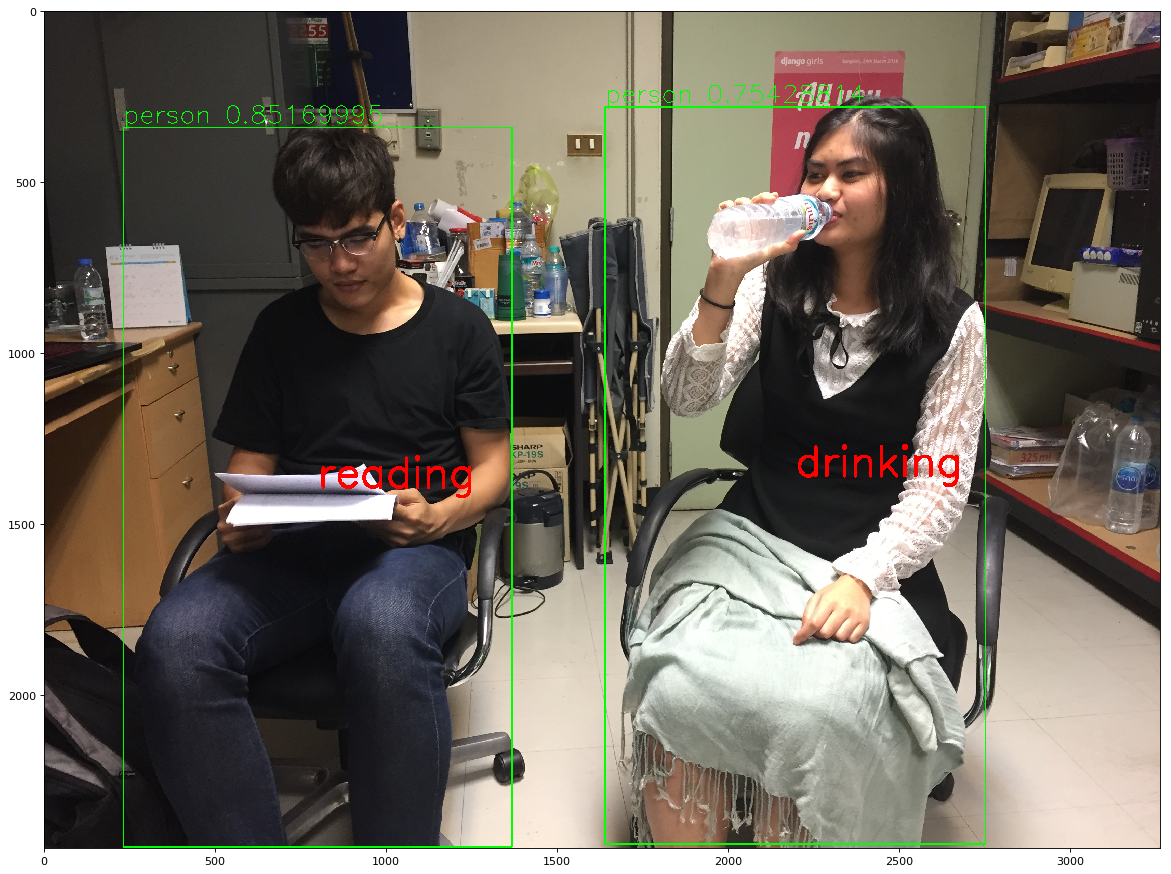

In [11]:
raw_image = cv2.imread('images/ait/act3.jpg')
image = raw_image.copy()
start = time.time()
boxes = yolo.predict(image)
end = time.time()
# print(boxes)
print(len(boxes), 'boxes are found')
print('Detection Time: %lf' % (end - start))
filtered_boxes = []
for b in boxes:
    if b.score >= MIN_CONFIDENCE:
        filtered_boxes.append(b)

boxes = filtered_boxes
image = draw_boxes(image, boxes, config['model']['labels'])
# fig = plt.figure(figsize=(18, 16), dpi= 80)
# print("Output From Detection!")
# plt.imshow(image[:,:,::-1]); plt.show()

crop_images = crop_people(boxes, raw_image)
crop_images = crop_images * 1.0/255.
start = time.time()
out_labels = get_predict_labels(activity.predict(crop_images))
end = time.time()
print('Activity Recognition Time: %lf' % (end - start))
for i in range(len(out_labels)):
    lb = out_labels[i]
    bbox = boxes[i]
    box_x_min = bbox.xmin* image.shape[1]
    box_x_max = bbox.xmax* image.shape[1]
    box_y_min = bbox.ymin* image.shape[0]
    box_y_max = bbox.ymax* image.shape[0]
    text_loc_x = int( box_x_min + ( (box_x_max - box_x_min) / 2.) )
    text_loc_y = int(box_y_min + ( (box_y_max - box_y_min) / 2.) )
    
    cv2.putText(image ,lb, (text_loc_x, text_loc_y), cv2.FONT_HERSHEY_SIMPLEX, 4, (0,0,255), 10 )

fig = plt.figure(figsize=(18, 16), dpi= 80)
plt.imshow(image[:,:,::-1]); plt.show()


# print("----------------------------------")
# for i in range( len(out_labels) ):
#     print(out_labels[i]) 
#     fig = plt.figure(figsize=(18, 16), dpi= 80)
#     plt.imshow(crop_images[i,:,:,::-1]); plt.show()
#     print("----------------------------------")
    
# fig = plt.figure(figsize=(18, 16), dpi= 80)
# plt.imshow(image[:,:,::-1]); plt.show()

In [ ]:
cv2.imwrite('out_result.png',image)

In [ ]:
image.shape

In [ ]:
out.shape

In [ ]:
# plt.imshow(out[3,:,:,::-1]); plt.show()

In [ ]:
predictions

In [ ]:
def get_predict_labels(predictions):
    out_labels = []
    for i in range(predictions.shape[0]):
        out_labels.append( activity_labels[np.argmax(predictions[i])])
    return out_labels
    

In [ ]:
activi

In [ ]:
cv2.imwrite('out_vgg.png',image)

In [ ]:
image.shape